In [133]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
# from openpyxl import load_workbook

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

data_dir = '../lithium_data&analysis/Data'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerryc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jerryc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [10]:
Theme = pd.read_csv(f'{data_dir}/gTAXONOMY--GKG THEMES - Sheet1.csv')
Theme

Descriptions = Theme['Description']
Descriptions = Descriptions.astype(str).tolist()

In [5]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    processed_text = ' '.join(tokens)
    return processed_text

In [6]:
# description text preprocessing
processed_descriptions = [preprocess_text(desc) for desc in Descriptions]

# feature extraction
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_descriptions)

# k-means clustering
k = 5  # number of desired clusteres
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(X)
cluster_labels = kmeans.labels_

# Concat cluster labels to Themes
Theme['cluster_label'] = cluster_labels
Theme = Theme[['Name', 'Description', 'cluster_label']]
Theme = Theme.rename({'Name': 'theme', 'Description': 'description'})
Theme

,Name,Description,cluster_label
0,ACT_FORCEPOSTURE,Actions relating to changes in force posture,3
1,ACT_HARMTHREATEN,Actions relating to harming or threatening,3
2,ACT_MAKESTATEMENT,Actions relating to making a statement,3
3,ACT_YIELD,Actions relating to yielding,3
4,AFFECT,This broad category captures everything from b...,3
...,...,...,...
278,VIOLENT_UNREST,"Discussion of violent unrest, from rubber bull...",2
279,WATER_SECURITY,"Drought, water access, lack of rain, clean wat...",2
280,WHISTLEBLOWER,"Whistleblowers, document leaks, etc",2
281,WMD,"Weapons of mass distruction, from nuclear to b...",3


# Lithium Future Price Data Processing

* Currently, I am using a price series of Lithium futures. The first step is to identify dates with significant price changes from this price series. I have set a time range from 1 to 10 days and a percentage change range from 0.01 to 0.17. I have written a nested for loop to investigate cumulative returns for each combination of days and percentage changes, checking if they exceed thresholds such as 0.01, 0.02, up to 0.17. Therefore, there should be a total of 170 combinations of answers. Each combination represents a specific number of days and a specific percentage change, indicating dates where the cumulative return satisfies the condition. For example, (0.1, 10) represents dates where the cumulative return exceeds 0.1 after 10 days. After obtaining these 170 combinations of answers, I store them in a dictionary.

* Next, we need to use these dates to search for news articles published within those dates in the "lithium_merged" dataset. Again, I store the news articles in a dictionary. It is important to note that I merge combinations with the same percentage change because there might be duplicates. For instance, (0.1, 1) and (0.1, 2) may contain overlapping dates. Thus, merging them before searching for news articles is necessary.

* The above statement is an explanation of the approach based on price change
* Actually, we'll discuss two approaches. 
* The first one is filtering the news in t-1,t-2,...t-10, where t is the date of large price change 
* The second one is filtering the news in t-1,t-2,...t-10, where t is the date of large volatility change 

## Lithium Futures Spot Price Data preparation

In [7]:
def convert_string_to_numeric(s):
    """
    Convert strings like '5.74M' or '532.50K' to numeric values
    """
    s = str(s).replace(',', '')  # Remove commas
    if 'M' in s:
        return float(s.replace('M', '')) * 1e6
    elif 'K' in s:
        return float(s.replace('K', '')) * 1e3
    else:
        return float(s)

In [18]:
li_future = pd.read_excel(f'{data_dir}/Historical Prices (9).xlsx')

# Processing Dates
li_future['Date'] = li_future['Date'].str.replace('.', '')
li_future['Date'] = pd.to_datetime(li_future['Date'], format="%b %d, %Y")
li_future.set_index('Date', inplace=True)
li_future = li_future[::-1]

# Convert columns 'Open', 'High', 'Close', 'Low' from string to numeric
for col in ['Open', 'High', 'Close', 'Low']:
    li_future[col] = li_future[col].apply(convert_string_to_numeric)

# Log return & volatility calculation
li_future['log_return'] = np.log(li_future['Close']).diff() 
li_future['volatility'] = li_future['log_return'].rolling(window=5).std()
volatility_stats = li_future['volatility'].describe()

# Creating weekly dataset
li_future_weekly = li_future.copy()
li_future_weekly = li_future_weekly[li_future_weekly.index.dayofweek == 4] # Friday
li_future_weekly['Change %'] = li_future_weekly['Close'].pct_change()
li_future_weekly['log_return'] = np.log(li_future_weekly['Close']).diff() 
li_future_weekly['volatility'] = li_future_weekly['log_return'].rolling(window=7).std()

# Saving processed lithium future price data
li_future.to_csv("./lithium_dataset/lithium_future_prices.csv")
li_future_weekly.to_csv("./lithium_dataset/lithium_future_weekly_prices.csv")
volatility_stats

count    1491.000000
mean        0.005757
std         0.009649
min         0.000000
25%         0.000000
50%         0.002933
75%         0.008313
max         0.083646
Name: volatility, dtype: float64

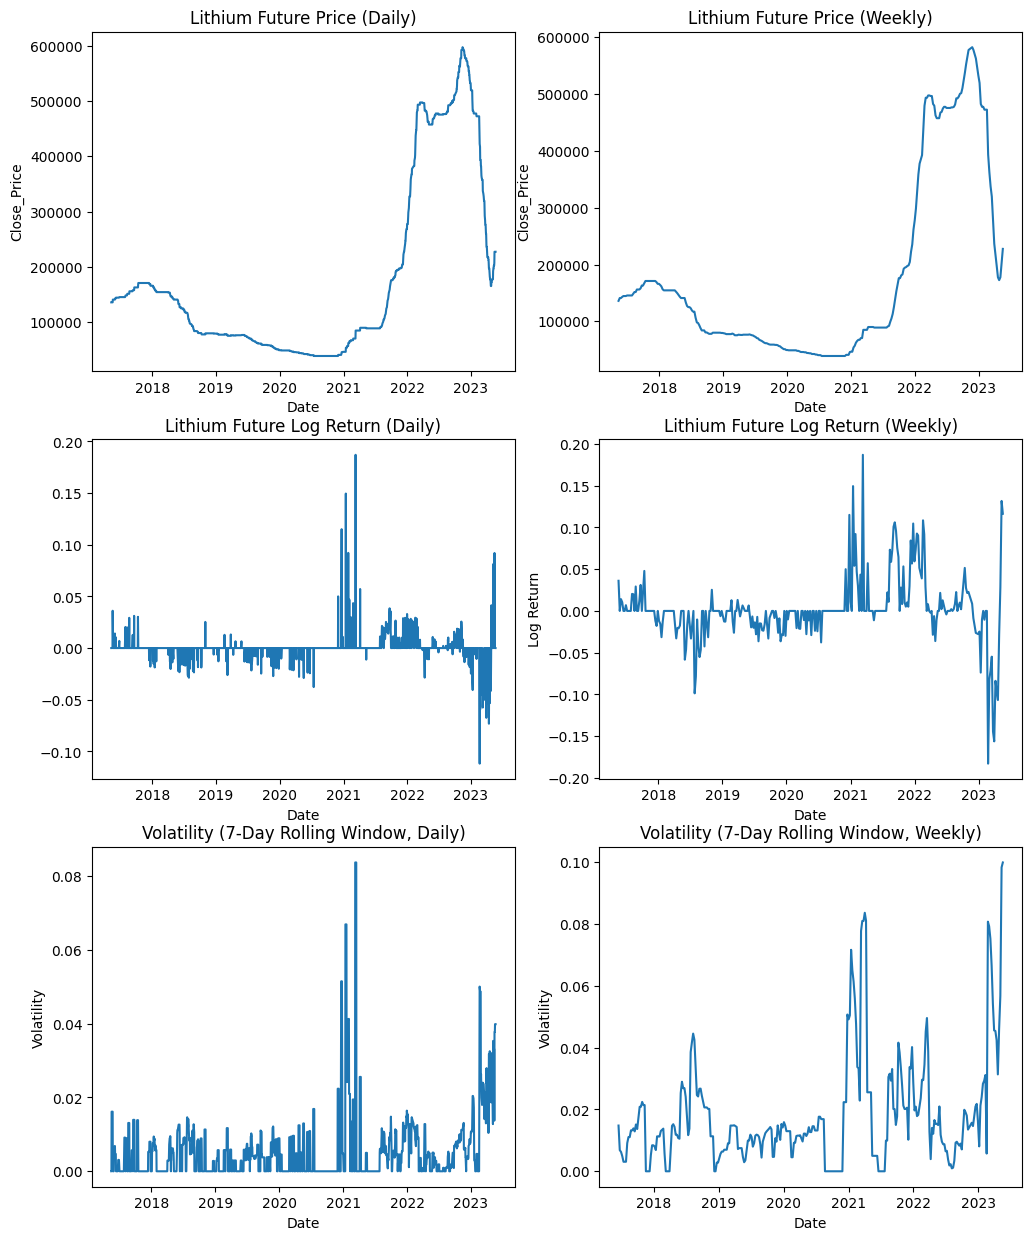

In [206]:
# Ploting historical close prices
fig, ax = plt.subplots(3, 2)

ax[0,0].plot(li_future['Close'])
ax[0,0].set_title('Lithium Future Price (Daily)')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Close_Price')

# ax[1,0].bar(li_future.index, li_future['log_return'])
ax[1,0].plot(li_future['log_return'])
ax[1,0].set_title('Lithium Future Log Return (Daily)')
ax[1,0].set_xlabel('Date')
ax[1,1].set_ylabel('Log Return')

ax[2,0].plot(li_future['volatility'])
ax[2,0].set_title('Volatility (7-Day Rolling Window, Daily)')
ax[2,0].set_xlabel('Date')
ax[2,0].set_ylabel('Volatility')


ax[0,1].plot(li_future_weekly['Close'])
ax[0,1].set_title('Lithium Future Price (Weekly)')
ax[0,1].set_xlabel('Date')
ax[0,1].set_ylabel('Close_Price')

# ax[1,1].bar(li_future_weekly.index, li_future_weekly['log_return'])
ax[1,1].plot(li_future_weekly['log_return'])
ax[1,1].set_title('Lithium Future Log Return (Weekly)')
ax[1,1].set_xlabel('Date')
ax[1,1].set_ylabel('Log Return')

ax[2,1].plot(li_future_weekly['volatility'])
ax[2,1].set_title('Volatility (7-Day Rolling Window, Weekly)')
ax[2,1].set_xlabel('Date')
ax[2,1].set_ylabel('Volatility')

fig.set_figheight(15)
fig.set_figwidth(12)

plt.show()

## Filter the news based on price change

### Route 1: Using daily price dataset, filter based on conbination of observation interval (1-7) and threshold (|price change| >= 0.01, 0.02... 0.25), generate combination matrix, and store filtered dates in a dictionary

<Axes: >

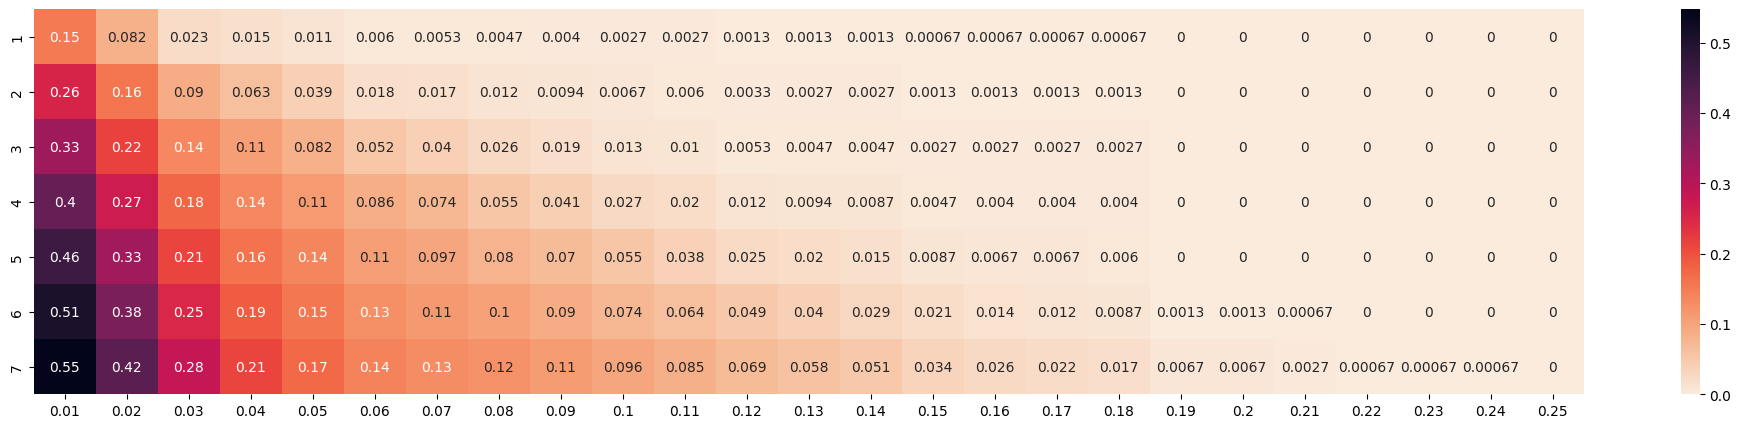

In [30]:
intervals = 7
thresholds = [0.01 * (i+1) for i in range(25)]
results_daily = {}

# First find dates where price change 
for i in range(intervals, len(li_future)):
    current_date = li_future.index[i]
    
    for j in range(1, intervals+1):
        past_date = li_future.index[i - j]
        current_price = li_future.loc[current_date, 'Close']
        past_price = li_future.loc[past_date, 'Close']
        past_changes = np.log(current_price/past_price) # log return
        # past_changes = current_price/past_price - 1 # percentage change
        
        for threshold in thresholds:
            if abs(past_changes) >= threshold:
                key = (threshold, j)
                if key not in results_daily:
                    results_daily[key] = []
                results_daily[key].append((past_date, current_date, j))


# Display frequency heatmap, where frequency = number of occurance of days that matches (threshold, interval) requirement / total number of days
frequencies = pd.DataFrame(columns=[str(i) for i in thresholds], index=[str(i) for i in range(1,intervals+1)])
for i in thresholds:
    for j in range(1, intervals+1):
        if (i, j) in results_daily:
            frequencies.loc[str(j),str(i)] = float(len(results_daily[(i,j)]))
        else:
            frequencies.loc[str(j),str(i)] = float(0)

frequencies = frequencies / len(li_future)
frequencies = frequencies.astype(float)

# SNS Heatmap
fig, ax = plt.subplots(figsize = (25, 5))
sns.heatmap(frequencies, annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True))

### Route 2: Using weekly dataset, filter dates based on weekly price change thresholds

297


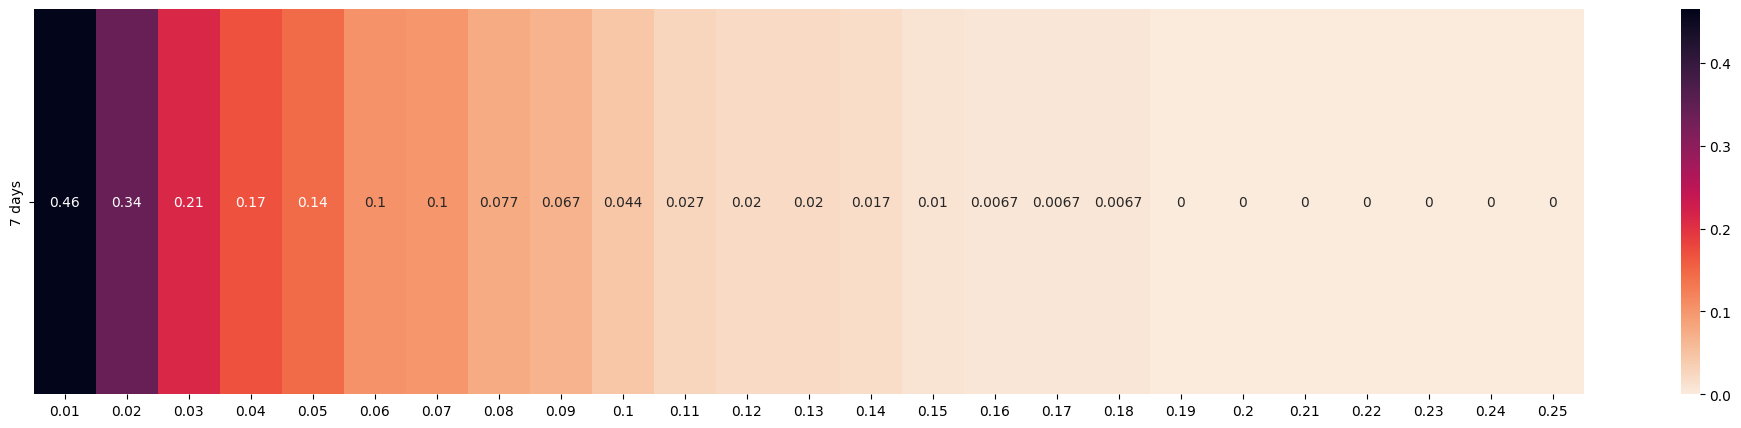

In [47]:
thresholds = [0.01 * (i+1) for i in range(25)]
results_weekly = {
    'combined': {},
    'up': {},
    'down': {}
}

# First find dates where price change 
for i in range(1, len(li_future_weekly)):
    current_date = li_future_weekly.index[i]
    log_return = li_future_weekly.loc[current_date,'log_return']
    for threshold in thresholds:
        if abs(log_return) >= threshold:
            # days where absolute value of log return exceeds threshold
            if threshold not in results_weekly['combined']:
                results_weekly['combined'][threshold] = []
            results_weekly['combined'][threshold].append((current_date, log_return))
            # days where log return is positive and > threshold
            if log_return >= threshold:
                if threshold not in results_weekly['up']:
                    results_weekly['up'][threshold] = []
                results_weekly['up'][threshold].append((current_date, log_return))
            # days where log return is negative and < threshold
            elif log_return <= -threshold:
                if threshold not in results_weekly['down']:
                    results_weekly['down'][threshold] = []
                results_weekly['down'][threshold].append((current_date, log_return))

# Display frequency heatmap, where frequency = number of occurance of days that matches (threshold, interval) requirement / total number of days
frequencies = pd.DataFrame(columns=[str(i) for i in thresholds], index=["7 days"])
for i in thresholds:
    if i in results_weekly['combined']:
        frequencies.loc['7 days',str(i)] = float(len(results_weekly['combined'][i]))
    else:
        frequencies.loc['7 days',str(i)] = float(0)

frequencies = frequencies / len(li_future_weekly)
frequencies = frequencies.astype(float)

# SNS Heatmap
fig, ax = plt.subplots(figsize = (25, 5))
sns.heatmap(frequencies, annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True))
print(len(li_future_weekly))

In [256]:
# Import Lithium_merged
lithium_news = pd.read_csv(f'{data_dir}lithium_merged.csv')
lithium_news.set_index('DATE', inplace=True)
lithium_news.index = pd.to_datetime(lithium_news.index, format = '%Y%m%d%H%M%S')
lithium_news = lithium_news.sort_index(ascending = True)

# Import upstream news data
lithium_news_upstream = pd.read_excel(f'{data_dir}upstream_source.xlsx')
lithium_news_upstream.set_index('DATE', inplace=True)
lithium_news_upstream.index = pd.to_datetime(lithium_news_upstream.index, format = '%Y%m%d%H%M%S')
lithium_news_upstream = lithium_news_upstream.sort_index(ascending = True)

# Import downstream news data
lithium_news_downstream = pd.read_excel(f'{data_dir}downstream_source.xlsx')
lithium_news_downstream.set_index('DATE', inplace=True)
lithium_news_downstream.index = pd.to_datetime(lithium_news_downstream.index, format = '%Y%m%d%H%M%S')
lithium_news_downstream = lithium_news_downstream.sort_index(ascending = True)


/usr/local/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Group news by week (ending on Friday, which matches our weekly close price data) and compute some summary statistics, including average tone, count, variance, themes, themes count, etc. All this data is stored in a large dataframe "li_price_news"

In [154]:
def process_news_data(news_df):
    res = {}
    news_df.loc[:,'FinalThemes'] = news_df['FinalThemes'].map(lambda x: x.split(','))

    res['news_urls'] = news_df['DocumentIdentifier'].tolist()
    res['tone_mean'] = news_df['V2Tone'].mean()
    res['tone_std'] = news_df['V2Tone'].std()
    res['news_count'] = len(news_df)
    themes = sorted(news_df['FinalThemes'].explode().tolist())
    # unique_themes = sorted(list(set(themes)))
    res['news_themes'] = themes
    res['news_theme_occurence'] = {item: themes.count(item) for item in themes}

    return res

In [280]:
def group_news_by_rolling_window(news_window, price_window, price_df, news_df):

    res = pd.DataFrame(columns=['date', 'close', 'log_return', 'volatility', 'news_window', 'price_window', 'news_urls', 'tone_mean', 'tone_std', 'news_count', 'news_themes', 'news_theme_occurence'])

    # for date in price_df.index:
    #     news_start = date - timedelta(days=news_window)
    #     news_end = date
    #     weekly_news = news_df.loc[(news_df.index >= news_start) & (news_df.index <= news_end)]
    #     data = process_news_data(weekly_news)
    #     data['news_window'] = news_window
    #     data['date'] = date
    #     data['close'] = price_df.loc[date,'Close']
    #     data['log_return'] = price_df.loc[date,'log_return']
    #     data['volatility'] = price_df.loc[date,'volatility']
    #     li_price_news_oneweek = pd.DataFrame([data])
    #     res = pd.concat([res, li_price_news_oneweek])
    # res.set_index('date', inplace=True)

    for i in range(len(price_df)):
        end = price_df.index[i]
        news_start = price_df.index[i-news_window]
        price_start = price_df.index[i-price_window]

        weekly_news = news_df.loc[(news_df.index >= news_start) & (news_df.index <= end)]
        data = process_news_data(weekly_news)
        data['news_window'] = news_window
        data['price_window'] = price_window
        data['date'] = end
        data['close'] = price_df.loc[end,'Close']
        data['log_return'] = np.log(price_df.loc[end,'Close'] / price_df.loc[price_start,'Close'])
        data['volatility'] = price_df.loc[end,'volatility']
        li_price_news_oneline = pd.DataFrame([data])
        res = pd.concat([res, li_price_news_oneline])
    res.set_index('date', inplace=True)

    return res

## Exploratory analysis of relationships between lithium price dataset & news dataset

In [293]:
import scipy as sp

def exploratory_graph(price_news_df):

    ROUNDING = 6
    graphing_df = price_news_df.dropna()
    
    # Ploting historical close prices
    fig, ax = plt.subplots(3, 2)

    ax[0,0].plot(graphing_df['news_count'])
    ax[0,0].set_title('News Count vs. Date')

    ax[1,0].plot(graphing_df['tone_mean'])
    ax[1,0].set_title('Tone Mean vs. Date')

    ax[2,0].scatter(graphing_df['tone_std'], graphing_df['tone_mean'])
    ax[2,0].set_title('Tone Mean vs. Tone STD')


    ax[0,1].scatter(graphing_df['log_return'], graphing_df['tone_mean'], label='mean')
    linreg1 = sp.stats.linregress(graphing_df['log_return'], graphing_df['tone_mean'])
    m1, b1, r1 = linreg1.slope, linreg1.intercept, linreg1.rvalue
    ax[0,1].plot(graphing_df['log_return'], b1 + m1 * graphing_df['log_return'], color="tab:blue")

    ax[0,1].scatter(graphing_df['log_return'], graphing_df['tone_std'], label='std')
    linreg2 = sp.stats.linregress(graphing_df['log_return'], graphing_df['tone_std'])
    m2, b2, r2 = linreg2.slope, linreg2.intercept, linreg2.rvalue
    ax[0,1].plot(graphing_df['log_return'], b2 + m2 * graphing_df['log_return'], color="tab:orange")
    ax[0,1].set_title('Log Return vs. Tone Mean & STD')
    ax[0,1].legend()


    ax[1,1].scatter(graphing_df['log_return'], graphing_df['news_count'])
    linreg3 = sp.stats.linregress(graphing_df['log_return'], graphing_df['news_count'].astype(float))
    m3, b3, r3 = linreg3.slope, linreg3.intercept, linreg3.rvalue
    ax[1,1].plot(graphing_df['log_return'], b3 + m3 * graphing_df['log_return'], color="tab:blue")
    ax[1,1].set_title('Log Return vs. News Count')


    ax[2,1].scatter(graphing_df['volatility'], graphing_df['tone_mean'], label='mean')
    linreg4 = sp.stats.linregress(graphing_df['volatility'], graphing_df['tone_mean'])
    m4, b4, r4 = linreg4.slope, linreg4.intercept, linreg4.rvalue
    ax[2,1].plot(graphing_df['volatility'], b4 + m4 * graphing_df['volatility'], color="tab:blue")

    ax[2,1].scatter(graphing_df['volatility'], graphing_df['tone_std'], label='std')
    linreg5 = sp.stats.linregress(graphing_df['volatility'], graphing_df['tone_std'])
    m5, b5, r5 = linreg5.slope, linreg5.intercept, linreg5.rvalue
    ax[2,1].plot(graphing_df['volatility'], b5 + m5 * graphing_df['volatility'], color="tab:orange")
    ax[2,1].set_title('Volatility vs. Tone Mean & STD')
    ax[2,1].legend()


    fig.set_figheight(15)
    fig.set_figwidth(12)

    print(f"1. Log return vs. tone mean: y = {m1:.{ROUNDING}f}x + {b1:.{ROUNDING}f},   R-Squared = {r1**2:.{ROUNDING}f}")
    print(f"2. Log return vs. tone std: y = {m2:.{ROUNDING}f}x + {b2:.{ROUNDING}f},   R-Squared = {r2**2:.{ROUNDING}f}")
    print(f"3. Log return vs. news count: y = {m3:.{ROUNDING}f}x + {b3:.{ROUNDING}f},   R-Squared = {r3**2:.{ROUNDING}f}")
    print(f"4. Volatility vs. tone mean: y = {m4:.{ROUNDING}f}x + {b5:.{ROUNDING}f},   R-Squared = {r4**2:.{ROUNDING}f}")
    print(f"5. Volatility vs. tone std: y = {m4:.{ROUNDING}f}x + {b5:.{ROUNDING}f},   R-Squared = {r5**2:.{ROUNDING}f}")
    plt.show()

In [301]:
DEFAULT_NEWS_WINDOW = 1
DEFAULT_PRICE_WINDOW = 1

li_price_news = group_news_by_rolling_window(1, 1, li_future_weekly, lithium_news)
li_price_news_day = group_news_by_rolling_window(5, 1, li_future, lithium_news)
# li_price_news_upstream = group_news_by_rolling_window(DEFAULT_NEWS_WINDOW, li_future_weekly, lithium_news_upstream)
# li_price_news_downstream = group_news_by_rolling_window(DEFAULT_NEWS_WINDOW, li_future_weekly, lithium_news_downstream)
# li_price_news2 = group_news_by_rolling_window(14, li_future_weekly, lithium_news)
# li_price_news3 = group_news_by_rolling_window(1, li_future, lithium_news)
display(li_price_news_day.head(10))

,close,log_return,volatility,news_window,price_window,news_urls,tone_mean,tone_std,news_count,news_themes,news_theme_occurence
date,,,,,,,,,,,
2017-05-10,136000.0,-0.514495,NaN,5,1,[],NaN,NaN,0,[],{}
2017-05-11,136000.0,0.000000,NaN,5,1,[],NaN,NaN,0,[],{}
2017-05-12,136000.0,0.000000,NaN,5,1,[],NaN,NaN,0,[],{}
2017-05-15,136000.0,0.000000,NaN,5,1,[],NaN,NaN,0,[],{}
2017-05-16,136000.0,0.000000,NaN,5,1,[],NaN,NaN,0,[],{}
2017-05-17,136000.0,0.000000,0.000000,5,1,[http://scvnews.com/2017/05/09/biosolar-begins...,1.129846,2.386269,22,"[AGRICULTURE, BAN, ECON_DEBT, ECON_DEBT, ECON_...","{'AGRICULTURE': 1, 'BAN': 1, 'ECON_DEBT': 5, '..."
2017-05-18,136000.0,0.000000,0.000000,5,1,[https://www.bloomberg.com/news/articles/2017-...,1.580455,2.413336,15,"[AGRICULTURE, ECON_DEBT, ECON_ENTREPRENEURSHIP...","{'AGRICULTURE': 1, 'ECON_DEBT': 1, 'ECON_ENTRE..."
2017-05-19,141000.0,0.036105,0.016147,5,1,[http://www.cmswire.com/digital-experience/lit...,2.426267,2.846813,9,"[ECON_DEBT, ECON_ENTREPRENEURSHIP, ECON_ENTREP...","{'ECON_DEBT': 1, 'ECON_ENTREPRENEURSHIP': 4, '..."
2017-05-22,141000.0,0.000000,0.016147,5,1,[http://www.einnews.com/pr_news/381208080/cypr...,2.438140,3.043133,8,"[ECON_DEBT, ECON_ENTREPRENEURSHIP, ECON_ENTREP...","{'ECON_DEBT': 1, 'ECON_ENTREPRENEURSHIP': 4, '..."


1. Log return vs. tone mean: y = 2.462602x + 0.346786,   R-Squared = 0.001925
2. Log return vs. tone std: y = 3.490917x + 1.605508,   R-Squared = 0.006440
3. Log return vs. news count: y = -11.558939x + 22.248267,   R-Squared = 0.000080
4. Volatility vs. tone mean: y = 6.124496x + 1.622157,   R-Squared = 0.006662
5. Volatility vs. tone std: y = 6.124496x + 1.622157,   R-Squared = 0.002076


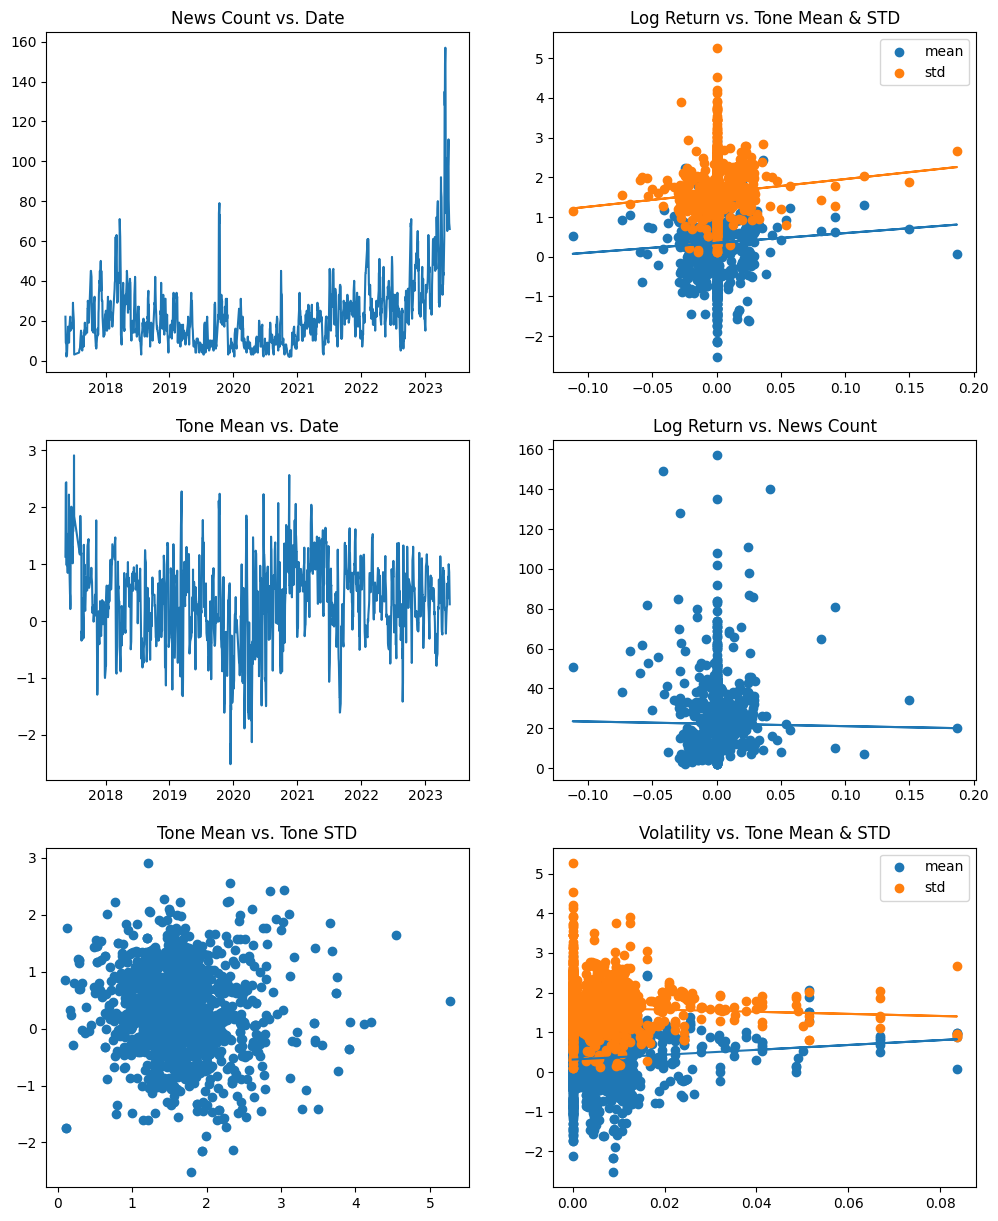

In [302]:
exploratory_graph(li_price_news_day)